# Task 1.2 [x] - Next value prediction with varying window size and shift

> Luca Laboccetta,  
> Giorgio Andronico 

## Data understanding

### Initial data collection

Boilerplate code: importing useful modules, choosing compute backend, mounting Google Drive

In [ ]:
import keras
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils.vis_utils import plot_model
from google.colab import drive
import tensorflow as tf
!pip install -q -U keras-tuner
import keras_tuner as kt

# Choose computing backend
computing_resource = tf.test.gpu_device_name()
if "GPU" not in computing_resource:
  computing_resource = "/CPU:0"
print(f"Computing resource: {computing_resource}")

# Mount Google Drive
drive.mount('/content/drive')

Computing resource: /device:GPU:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load *Healthware* dataset, both train and test. Loading *x* column only, as this notebook focuses only on analyzing this column

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/DeepLearning/Datasets/Progetto/train.csv").drop('y', 1).drop('z', 1)
test_set = pd.read_csv("/content/drive/MyDrive/DeepLearning/Datasets/Progetto/test.csv").drop('y', 1).drop('z', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


## Data preparation

#### Normalization and splitting

Normalizing train data in a -1:1 range

In [ ]:
mean = train.mean()
std = train.std()
train = (train - mean) / std
train

,x
0,-0.318759
1,-0.688905
2,-0.552642
3,-1.292934
4,-0.835336
...,...
144906,0.866929
144907,0.866929
144908,0.866929
144909,0.866929


Normalizing test data in a -1:1 range

In [ ]:
mean = test_set.mean()
std = test_set.std()
test = (test_set - mean) / std
test_set

,x
0,621
1,622
2,598
3,502
4,494
...,...
148366,1009
148367,1009
148368,1009
148369,1009


Creation of the validation set, extracting 30% of the training set

In [ ]:
n_rows_train = round(len(train)*0.7)
train_set = train[:n_rows_train]
validation_set = train[n_rows_train:]
validation_set.index = np.arange(0, len(validation_set))
validation_set

,x
0,0.332048
1,0.315777
2,0.429668
3,0.612708
4,0.431702
...,...
43468,0.866929
43469,0.866929
43470,0.866929
43471,0.866929


#### Labeling the dataset

Defining the windowing function

In [ ]:
def generate_windows(df, window_size, window_shift):
    windows = []
    labels = []

    for i in range(0, len(df), window_shift):
        if (i + window_size >= len(df)):
            break

        windows.append(df[i: i + window_size])
        labels.append(df.iloc[i + window_size])
    
    return np.array(windows, dtype=np.float32), np.array(labels, dtype=np.float32)

## Modeling



### Fitting and building

Defining a model building function

In [ ]:
def build_model(window_size):
    model = Sequential()
    model.add(LSTM(112, input_shape=(window_size, 1)))
    model.add(Dense(1)

    return model

Fitting and building the model with the best hyperparameters found in task 1.1. Doing this for several window sizes and shifts

In [ ]:
from sklearn.metrics import mean_absolute_error
history = {}
mae = {}

for shift in [3, 6, 12]:
  for windows_size in [15, 30, 60]:
    print(f'Window size: {windows_size}, window shift: {shift}')
    
    point_train, label_train = generate_windows(train_set, windows_size, shift)
    point_val, label_val = generate_windows(validation_set, windows_size, shift)
    point_test, label_test = generate_windows(test_set, windows_size, shift)
    
    model = build_model(windows_size)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
    
    with tf.device(computing_resource):
        history[shift, windows_size] = model.fit(point_train, 
                                                label_train, 
                                                epochs=20, 
                                                validation_data=(point_val, label_val))
        
    pred_test = model.predict(point_test)
    mae[shift, windows_size] = mean_absolute_error(label_test, pred_test)

Window size: 15, window shift: 3
Epoch 1/20
1057/1057 [==============================] - 13s 10ms/step - loss: 0.4779 - val_loss: 0.2760
Epoch 2/20
1057/1057 [==============================] - 10s 9ms/step - loss: 0.2882 - val_loss: 0.2338
Epoch 3/20
1057/1057 [==============================] - 9s 8ms/step - loss: 0.2840 - val_loss: 0.2562
Epoch 4/20
1057/1057 [==============================] - 10s 9ms/step - loss: 0.2840 - val_loss: 0.2315
Epoch 5/20
1057/1057 [==============================] - 10s 9ms/step - loss: 0.2846 - val_loss: 0.2613
Epoch 6/20
1057/1057 [==============================] - 11s 11ms/step - loss: 0.2816 - val_loss: 0.2381
Epoch 7/20
1057/1057 [==============================] - 10s 9ms/step - loss: 0.2832 - val_loss: 0.2335
Epoch 8/20
1057/1057 [==============================] - 10s 9ms/step - loss: 0.2849 - val_loss: 0.2415
Epoch 9/20
1057/1057 [==============================] - 11s 11ms/step - loss: 0.2823 - val_loss: 0.2430
Epoch 10/20
1057/1057 [===============

## Evaluation

### Losses by size and shift

Below there are a series of plots which show how training and validation losses vary according to different window sizes and shifts.

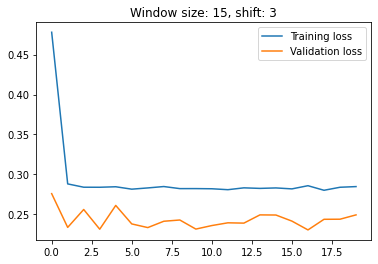

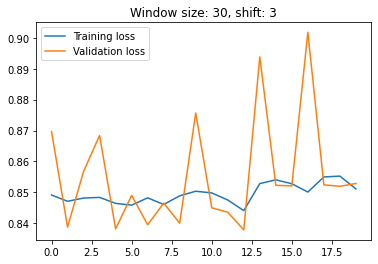

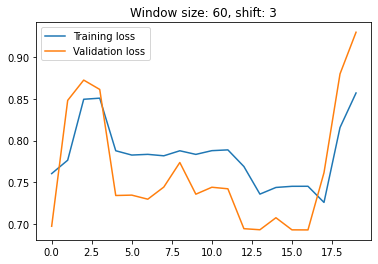

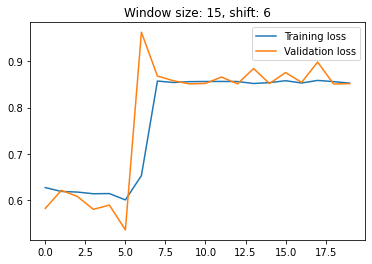

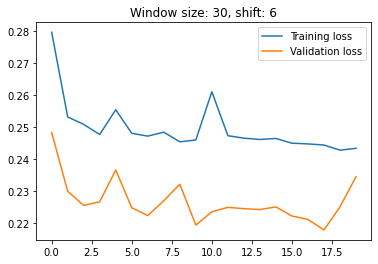

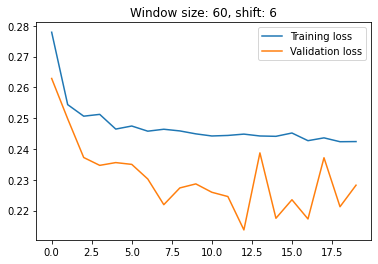

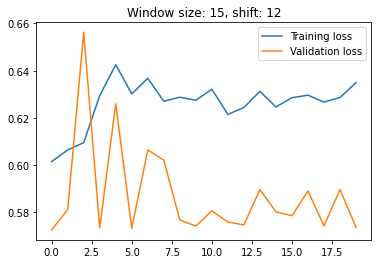

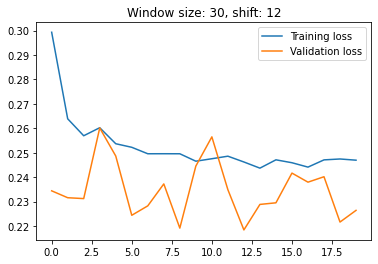

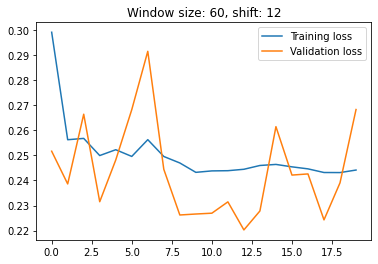

In [ ]:
for shift in [3, 6, 12]:
  for windows_size in [15, 30, 60]:
    loss = history[shift, windows_size].history['loss']
    val_loss = history[shift, windows_size].history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title(f'Window size: {windows_size}, shift: {shift}')
    plt.legend()
    plt.show()

Below there is a histogram which details the windowing influence in a better way.

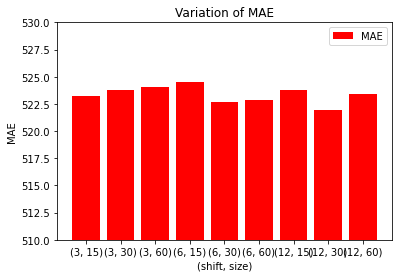

In [ ]:
keys = []
for key in mae.keys():
  keys.append(str(key))

plt.bar(keys, list(mae.values()), color='r', label='MAE')
plt.title('Variation of MAE')
plt.xlabel('(shift, size)')
plt.ylabel('MAE')
plt.ylim(70, 90)
plt.legend()
plt.show()